## Fine-Tuning de un Modelo LLM con adaptadores QLoRA Google Colab

Puntos clave de este Notebook (Fine Tuning Pipeline)
1.  **Instalar** las dependencias necesarias (`unsloth`, `transformers`, `datasets`, etc.).
2.  **Montar Google Drive** para cargar el dataset y guardar el modelo final.
3.  **Cargar** un modelo base (`unsloth/...`).
4.  **Cargar y preparar** los datasets.
5.  **Ejecutar** el proceso de fine-tuning.
6.  **Probar** el modelo afinado.
7.  **Guardar** el adaptador QLoRA en tu Google Drive.

In [ ]:
#!pip install unsloth trl peft accelerate bitsandbytes

In [ ]:
# Solo necesario en caso de errores
#!pip uninstall -y unsloth transformers peft trl accelerate bitsandbytes

Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0


In [ ]:
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install matplotlib seaborn pandas scikit-learn datasets scipy
!pip install --upgrade transformers

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-9b6ouq5k/unsloth_3e918301a26a4514b1e339c165218284
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-9b6ouq5k/unsloth_3e918301a26a4514b1e339c165218284
  Resolved https://github.com/unslothai/unsloth.git to commit d5b61a6bc6d546ca6afa9043f9c4b15713ecac62
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 361.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 438.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 311.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 427.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.6/180.6 kB 424.9 MB/s eta 0:

In [ ]:
!pip install torchinfo torchview graphviz
!apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ============================================================================
# PARCHE DE EMERGENCIA PARA UNSLOTH (EJECUTAR ESTO PRIMERO)
# Arregla el error: TypeError: get_transformers_model_type() got unexpected keyword...
# ============================================================================
import unsloth.models.loader as loader_module

original_get_model_type = loader_module.get_transformers_model_type


def patched_get_model_type(config, *args, **kwargs):

    if 'trust_remote_code' in kwargs:
        kwargs.pop('trust_remote_code')

    return original_get_model_type(config, *args, **kwargs)

loader_module.get_transformers_model_type = patched_get_model_type


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
✅ Librería Unsloth parcheada en memoria. El error 'trust_remote_code' ha sido eliminado.
Ahora puedes ejecutar tu celda original sin cambios.


In [ ]:

import torch
import json
from unsloth import FastLanguageModel
from transformers import TrainingArguments, EarlyStoppingCallback
from trl import SFTTrainer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from tqdm.auto import tqdm


max_seq_length =
dtype = None
load_in_4bit = True

model_name = "unsloth/Qwen3-4B-Instruct-2507"

try:
  print("Cargando modelo y tokenizador...")
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name = model_name,
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
  )
except Exception as e:
    print("\n⚠️ ALERTA DE NOMBRE DE MODELO:")
    print(f"Si falla la descarga, busca en HuggingFace el nombre exacto.")
    print("Prueba alternativo: 'Qwen/Qwen3-4B-Instruct'")
    raise e

print("Configurando PEFT (LoRA) para el modelo...")
model = FastLanguageModel.get_peft_model(
    model,
    r = 32,
    lora_alpha = 32,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
)
print("Modelo cargado y configurado (Full Linear Layers).")

Cargando modelo y tokenizador...
==((====))==  Unsloth 2025.12.7: Fast Qwen3 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Configurando PEFT (LoRA) para el modelo...


Unsloth 2025.12.7 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


Modelo cargado y configurado (Full Linear Layers).


In [ ]:
import json
train_path = "/content/drive/MyDrive/TFM (UOC & CAF)/Fine_Tuning/fine_tuning_train_500_dataset.json"
val_path =  "/content/drive/MyDrive//TFM (UOC & CAF)/Fine_Tuning/fine_tuning_validation_50.json"
test_path = "/content/drive/MyDrive/TFM (UOC & CAF)/Fine_Tuning/fine_tuning_50_test_dataset.json"

In [ ]:

file = json.load(open(train_path, "r"))
print(file[1])
file = json.load(open(val_path, "r"))
print(file[1])
file = json.load(open(test_path, "r"))
print(file[1])

{'input': 'Eres un meticuloso analista de datos experto en Jira. Tu única y exclusiva misión: es detectar de issues duplicados. NADA MÁS. Tu respuesta debe ser un payload JSON preciso.\n**ISSUE EN ANÁLISIS AHORA:** UCM-2001\n---\n### PROCESO DE RAZONAMIENTO Y REGLAS\n\nTu respuesta final **DEBE SER SIEMPRE** un payload JSON dentro de un bloque de código, conteniendo únicamente el campo `customfield_10602`. Sigue estos pasos para construirlo:\n\n**Paso 1: Tarea Única - Detección de Duplicados.**\n* Analiza el **CURRENT ISSUE** y compáralo con los **POTENTIALLY SIMILAR ISSUES**.\n* Abstrae el **significado central** de cada uno, ignorando diferencias superficiales en la redacción.\n* Basado en tu análisis, decide el valor para el campo `customfield_10602`.\n     * Si es duplicado, identifica **TODAS las claves** de los issues que sean similares (ej. `UCM-31`, `UCM-50`) y el valor será: "❗ Issue may be repeated or similar to UCM-31, UCM-50".\n    * Si es único, el valor será: "✔️ No dupli

In [ ]:
def format_to_chat(example):
    input_text = example.get("input", "")
    output_json = json.dumps(example.get("output", {}), ensure_ascii=False)

    messages = [
        {"role": "user", "content": input_text},
        {"role": "assistant", "content": output_json}
    ]

    return {
        "text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False),
        "original_input": input_text,
        "original_output": output_json
    }

print("Cargando datasets independientemente...")

# Train
train_dataset = load_dataset("json", data_files={"train": train_path})["train"]
train_dataset = train_dataset.map(format_to_chat)

# Validation
eval_dataset = load_dataset("json", data_files={"train": val_path})["train"]
eval_dataset = eval_dataset.map(format_to_chat)

# Test
test_dataset = load_dataset("json", data_files={"train": test_path})["train"]
test_dataset = test_dataset.map(format_to_chat)

print(f"\nResumen de Datos:")
print(f"  --> Train Set: {len(train_dataset)} ejemplos (Para entrenar)")
print(f"  --> Val Set:   {len(eval_dataset)} ejemplos (Para Early Stopping)")
print(f"  --> Test Set:  {len(test_dataset)} ejemplos (Para Accuracy final)")

Cargando datasets independientemente...


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/53 [00:00<?, ? examples/s]


Resumen de Datos:
  --> Train Set: 500 ejemplos (Para entrenar)
  --> Val Set:   50 ejemplos (Para Early Stopping)
  --> Test Set:  53 ejemplos (Para Accuracy final)


In [ ]:
import torch
import pandas as pd
from torchinfo import summary
from torchview import draw_graph


hyperparams_data = {
    "Parámetro": [
        "Base Model", "Max Seq Length", "Load in 4bit",
        "Eval_strategy", "Eval_steps", "Metric for best model",
        "Batch Size", "Learning Rate", "Epochs (calc)", "Optimizer", "Gradient Accumulation", "Weight Decay", "Warmup Steps", "Scheduler Type", "Load Best Model at end", "Early Stopping Patience"
    ],
    "Valor": [
        "Qwen3-4B-Instruct-2507", max_seq_length, str(load_in_4bit),
        "Steps", "20", "Eval loss",
        "2 (per device)", "2e-4", "4 (aprox)", "adamw_8bit","4 steps (Effective Batch = 8)",
        "0.01",
        "10",
        "Linear",
        "True",
        "3"
    ]
}

df_params = pd.DataFrame(hyperparams_data)
display(df_params)
config = model.config
gen_config = getattr(model, "generation_config", None)

spec_data = {
    "Especificación": [
        "Arquitectura",
        "Versión",
        "Parámetros (Reportados por objeto)",
        "Precisión (Dtype)",
        "Tamaño Vocabulario",
        "Longitud de Contexto (Max Modelo)",
        "Dimensión Embedding (Hidden Size)",
        "Número de Capas",
        "Cabezas de Atención",
        "Temperature (Default)",
        "Top P (Default)",
        "Top K (Default)",
        "Repetition Penalty"
    ],
    "Valor": [
        config.architectures[0] if config.architectures else "Desconocido",
        "4-bit Quantized / BNB-NF4",
        f"{model.num_parameters() / 1e9:.2f} B",
        str(getattr(config, "torch_dtype", "N/A")),
        f"{config.vocab_size:,}",
        f"{config.max_position_embeddings:,}",
        str(config.hidden_size),
        str(config.num_hidden_layers),
        str(config.num_attention_heads),
        str(getattr(gen_config, "temperature", "N/A")),
        str(getattr(gen_config, "top_p", "N/A")),
        str(getattr(gen_config, "top_k", "N/A")),
        str(getattr(gen_config, "repetition_penalty", "N/A"))
    ]
}
df_spec = pd.DataFrame(spec_data)
pd.set_option('display.max_colwidth', None)
display(df_spec)

,Parámetro,Valor
0,Base Model,Qwen3-4B-Instruct-2507
1,Max Seq Length,2048
2,Load in 4bit,True
3,Eval_strategy,Steps
4,Eval_steps,20
5,Metric for best model,Eval loss
6,Batch Size,2 (per device)
7,Learning Rate,2e-4
8,Epochs (calc),4 (aprox)
9,Optimizer,adamw_8bit


`torch_dtype` is deprecated! Use `dtype` instead!


,Especificación,Valor
0,Arquitectura,Qwen3ForCausalLM
1,Versión,4-bit Quantized / BNB-NF4
2,Parámetros (Reportados por objeto),4.09 B
3,Precisión (Dtype),torch.float16
4,Tamaño Vocabulario,"151,936"
5,Longitud de Contexto (Max Modelo),"262,144"
6,Dimensión Embedding (Hidden Size),2560
7,Número de Capas,36
8,Cabezas de Atención,32
9,Temperature (Default),0.7


In [ ]:
import pandas as pd

peft_config = model.peft_config['default']

train_data = {
    "Parámetro": [
        "Modelo Base",
        "Rango LoRA (r)",
        "Alpha (Escalado)",
        "Dropout",
        "Módulos Adaptados (Target)",
        "Cuantización",
        "Gradient Checkpointing"
    ],
    "Valor": [
        "Qwen3-4B-Instruct",
        str(peft_config.r),
        str(peft_config.lora_alpha),
        str(peft_config.lora_dropout),
        "All Linear Layers (Attention + MLP)",
        "4-bit (NF4)",
        "True (Unsloth optimized)"
    ]
}

df_train = pd.DataFrame(train_data)
display(df_train.style.set_caption("Tabla 3.2.1: Configuración adaptador QLoRA"))


,Parámetro,Valor
0,Modelo Base,Qwen3-4B-Instruct
1,Rango LoRA (r),32
2,Alpha (Escalado),32
3,Dropout,0
4,Módulos Adaptados (Target),All Linear Layers (Attention + MLP)
5,Cuantización,4-bit (NF4)
6,Gradient Checkpointing,True (Unsloth optimized)


In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        optim = "adamw_8bit",
        weight_decay = 0.01,
        eval_strategy = "steps",
        eval_steps = 20,
        save_strategy = "steps",
        save_steps = 20,
        logging_steps = 5,
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    ),
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

print("¡Iniciando entrenamiento!")
print("El sistema parará automáticamente si el modelo deja de mejorar.")
trainer_stats = trainer.train()
print("¡Entrenamiento completado!")

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/494 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/50 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


¡Iniciando entrenamiento!
El sistema parará automáticamente si el modelo deja de mejorar.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 494 | Num Epochs = 4 | Total steps = 200
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 66,060,288 of 4,088,528,384 (1.62% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
20,0.454300,0.340320
40,0.222000,0.272455
60,0.210600,0.254577
80,0.176200,0.250450
100,0.165800,0.246722
120,0.169600,0.259441
140,0.149900,0.251460
160,0.132600,0.259494


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


¡Entrenamiento completado!


In [ ]:

import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
from tqdm import tqdm

FastLanguageModel.for_inference(model)

y_true = []
y_pred = []

print("Generando predicciones sobre el conjunto de test...")


for i in tqdm(range(len(test_dataset))):
    example = test_dataset[i]
    input_text = example["original_input"]
    real_output_str = example["original_output"]
    is_duplicate_real = 1 if "Issue may be repeated" in real_output_str else 0
    y_true.append(is_duplicate_real)
    messages = [{"role": "user", "content": input_text}]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=64,
        use_cache=True,
        temperature=0.1
    )
    decoded_output = tokenizer.batch_decode(outputs)[0]
    response_part = decoded_output.split("assistant")[-1]

    if "Issue may be repeated" in response_part:
        y_pred.append(1)
    else:
        y_pred.append(0)


# CALCULAR MÉTRICAS REALES
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

df_results = pd.DataFrame({'Real': y_true, 'Pred': y_pred})
def get_type(row):
    if row['Real']==0 and row['Pred']==0: return "TN"
    if row['Real']==0 and row['Pred']==1: return "FP"
    if row['Real']==1 and row['Pred']==0: return "FN"
    if row['Real']==1 and row['Pred']==1: return "TP"
df_results["Tipo"] = df_results.apply(get_type, axis=1)

print("✅ Métricas calculadas con datos REALES.")
print(f"Accuracy: {acc:.2%}")

Generando predicciones sobre el conjunto de test...


100%|██████████| 53/53 [02:46<00:00,  3.15s/it]

✅ Métricas calculadas con datos REALES.
Accuracy: 98.11%


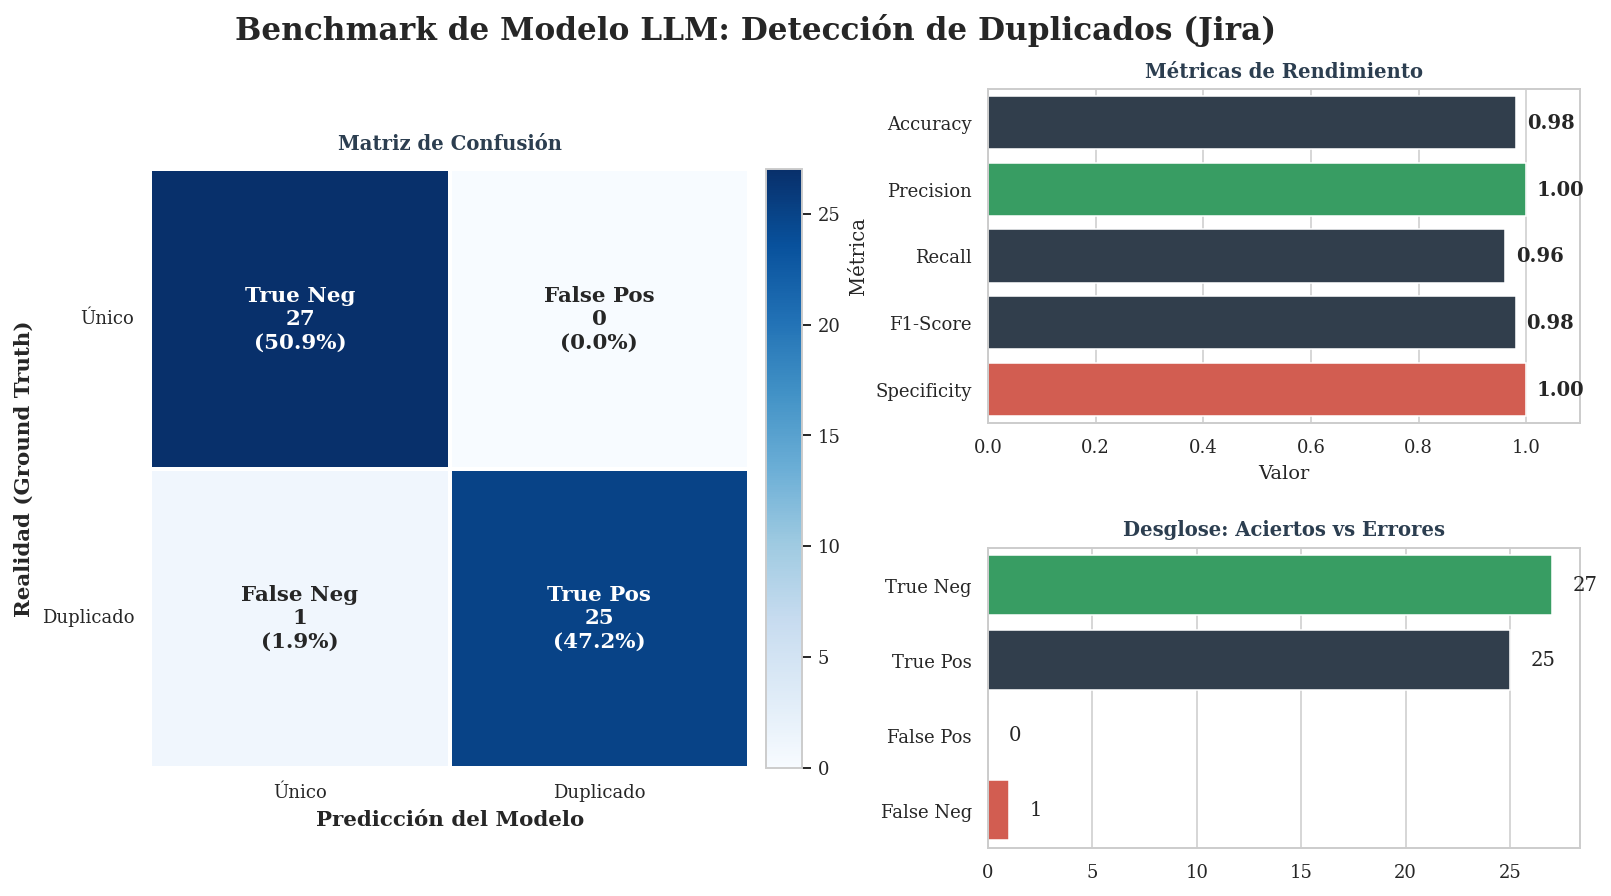

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable


sns.set_theme(style="whitegrid", context="paper", font_scale=1.05)
plt.rcParams['figure.dpi'] = 140
plt.rcParams['font.family'] = 'serif'


fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(3, 3, width_ratios=[1.1, 1.0, 0.6], height_ratios=[1.0, 0.9, 0.6],
                      wspace=0.35, hspace=0.45)

ax_hm = fig.add_subplot(gs[0:2, 0])
group_names = ['True Neg','False Pos','False Neg','True Pos']
counts = cm.flatten()
total = cm.sum() if cm.sum() > 0 else 1
group_pct = [f"{v/total:.1%}" for v in counts]
labels = [f"{n}\n{c}\n({p})" for n, c, p in zip(group_names, counts, group_pct)]
labels = np.array(labels).reshape(2, 2)

sns.heatmap(cm, annot=labels, fmt='', cmap="Blues", ax=ax_hm,
            annot_kws={"size":11, "weight":"bold"}, linewidths=1.2, linecolor='white', cbar=False, square=True)
ax_hm.set_xlabel('Predicción del Modelo', fontsize=11, weight='bold')
ax_hm.set_ylabel('Realidad (Ground Truth)', fontsize=11, weight='bold')
ax_hm.set_xticklabels(['Único', 'Duplicado'], rotation=0)
ax_hm.set_yticklabels(['Único', 'Duplicado'], rotation=0)
ax_hm.set_title('Matriz de Confusión', pad=10, weight='bold', color='#2C3E50')
divider = make_axes_locatable(ax_hm)
cax = divider.append_axes("right", size="6%", pad=0.12)
mappable = ScalarMappable(cmap="Blues")
mappable.set_array(cm)
fig.colorbar(mappable, cax=cax)
cax.yaxis.tick_right()

ax_metrics = fig.add_subplot(gs[0, 1])
metrics_data = {
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Specificity'],
    'Valor': [acc, precision, recall, f1, specificity]
}
df_metrics = pd.DataFrame(metrics_data)
metric_colors = ['#2C3E50', '#27AE60', '#2C3E50', '#2C3E50', '#E74C3C']

sns.barplot(x='Valor', y='Métrica', data=df_metrics, hue='Métrica', palette=metric_colors, orient='h', ax=ax_metrics, legend=False)
ax_metrics.set_xlim(0, 1.1) # Espacio extra para texto
ax_metrics.set_xlabel('Valor', fontsize=10)
ax_metrics.set_title('Métricas de Rendimiento', weight='bold', color='#2C3E50')
for i, (v, m) in enumerate(zip(df_metrics['Valor'], df_metrics['Métrica'])):
    ax_metrics.text(v + 0.02, i, f"{v:.2f}", va='center', fontweight='bold')

ax_errors = fig.add_subplot(gs[1, 1])
error_counts = df_results["Tipo"].value_counts().reindex(["TN", "TP", "FP", "FN"]).fillna(0).astype(int)
order = ["TN", "TP", "FP", "FN"]
labels_map = {"TN":"True Neg", "TP":"True Pos", "FP":"False Pos", "FN":"False Neg"}
colors_err = ['#27AE60', '#2C3E50', '#E74C3C', '#E74C3C']
labels_ordered = [labels_map[k] for k in order]

sns.barplot(x=error_counts.values, y=labels_ordered, hue=labels_ordered, palette=colors_err, ax=ax_errors, legend=False)
ax_errors.set_title('Desglose: Aciertos vs Errores', weight='bold', color='#2C3E50')
for i, val in enumerate(error_counts.values):
    ax_errors.text(val + max(1, 0.02 * np.max(error_counts.values)), i, str(int(val)), va='center')

plt.suptitle("Benchmark de Modelo LLM: Detección de Duplicados (Jira)", fontsize=16, weight='bold',x=0.33, y=0.98)
plt.subplots_adjust(top=0.92, left=0.06, right=0.94, bottom=0.06)

plt.show()

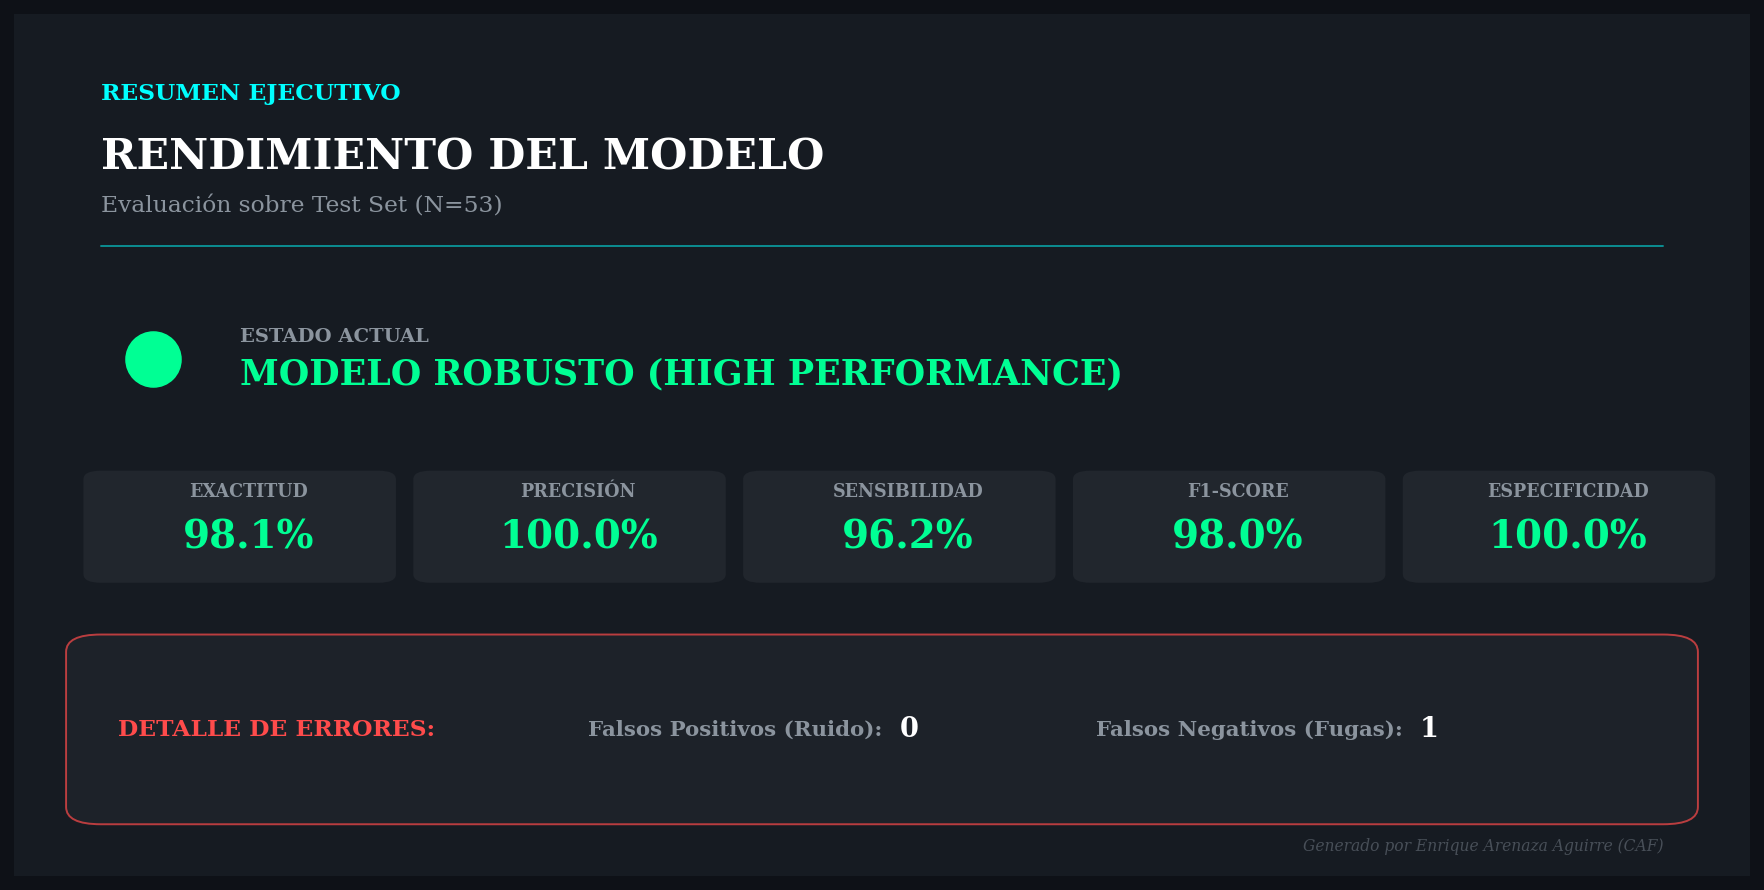

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch


c_bg = "#0E1117"
c_card = "#161B22"
c_cyan = "#00FFFF"
c_success = "#00FF94"
c_danger = "#FF4B4B"
c_text_main = "#FFFFFF"
c_text_sub = "#8B949E"


fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor(c_bg)
fig.patch.set_facecolor(c_bg)
ax.axis('off')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)


bg_box = FancyBboxPatch((0.02, 0.02), 0.96, 0.96, boxstyle="round,pad=0.03",
                        fc=c_card, ec="#30363D", lw=1.5)
ax.add_patch(bg_box)
ax.text(0.05, 0.90, "RESUMEN EJECUTIVO", fontsize=12, color=c_cyan, weight='bold')
ax.text(0.05, 0.82, "RENDIMIENTO DEL MODELO", fontsize=22, color=c_text_main, weight='bold')
ax.text(0.05, 0.77, f"Evaluación sobre Test Set (N={len(y_true)})", fontsize=12, color=c_text_sub)
ax.plot([0.05, 0.95], [0.73, 0.73], color=c_cyan, lw=1, alpha=0.5)

is_ready = acc > 0.85
status_text = "MODELO ROBUSTO (HIGH PERFORMANCE)" if is_ready else "OPTIMIZACIÓN REQUERIDA"
status_color = c_success if is_ready else c_danger
ax.scatter([0.08], [0.60], s=800, c=status_color, zorder=10)
ax.text(0.13, 0.62, "ESTADO ACTUAL", fontsize=10, color=c_text_sub, weight='bold')
ax.text(0.13, 0.57, status_text, fontsize=18, color=status_color, weight='bold')
metrics_data = [
    ("Exactitud", acc),
    ("Precisión", precision),
    ("Sensibilidad", recall),
    ("F1-Score", f1),
    ("Especificidad", specificity)
]

start_x = 0.05
gap = 0.19
y_pos = 0.35

for i, (label, value) in enumerate(metrics_data):
    x = start_x + (i * gap)
    m_box = FancyBboxPatch((x, y_pos), 0.16, 0.11, boxstyle="round,pad=0.01",
                           fc="#21262D", ec="none")
    ax.add_patch(m_box)
    ax.text(x + 0.085, y_pos + 0.09, label.upper(), fontsize=9, color=c_text_sub, ha='center', weight='bold')
    color_val = c_success if value > 0.85 else c_text_main
    ax.text(x + 0.085, y_pos + 0.03, f"{value:.1%}", fontsize=20, color=color_val, ha='center', weight='bold')

err_box = FancyBboxPatch((0.05, 0.08), 0.90, 0.18, boxstyle="round,pad=0.02",
                         fc="#21262D", ec=c_danger, lw=1, alpha=0.7)
ax.add_patch(err_box)
ax.text(0.06, 0.17, "DETALLE DE ERRORES:", fontsize=12, color=c_danger, weight='bold', va='center')
ax.text(0.50, 0.17, f"Falsos Positivos (Ruido):", fontsize=11, color=c_text_sub, weight='bold', ha='right', va='center')
ax.text(0.51, 0.17, f"{fp}", fontsize=14, color="white", weight='bold', ha='left', va='center')
ax.text(0.80, 0.17, f"Falsos Negativos (Fugas):", fontsize=11, color=c_text_sub, weight='bold', ha='right', va='center')
ax.text(0.81, 0.17, f"{fn}", fontsize=14, color="white", weight='bold', ha='left', va='center')
ax.text(0.95, 0.03, "Generado por Enrique Arenaza Aguirre (CAF)", fontsize=8, color="#484F58", ha='right', style='italic')
plt.show()

### 7. Guardar el Modelo en Google Drive (Formato GGUF)

Finalmente, guardamos el modelo afinado, en formato **GGUF** . (Debido a errores y limitaciones de RAM, finalmente se guarda el adaptador QLoRA, para poder hacer el merge con el modelo base en local y obtener el modelo final en GGUF) Si se dispone de una cuenta PRO de Collab se puede ejecutar directamente la celda completa y obtener le modelo final aqui.

In [ ]:

import torch
import gc

# Ruta  Drive
base_path = "/content/drive/MyDrive/TFM (UOC & CAF)/Fine_Tuning/mnt/models"
adapter_path = f"{base_path}/Jirax_LoRA_Adapters"
gguf_path = f"{base_path}/Jirax_GGUF"

# Guardar unicamente el adaptador
model.save_pretrained(adapter_path)
tokenizer.save_pretrained(adapter_path)


# A partir de este punto comienza el merge, que necesita una ampliación de la RAM para poder ejecutarse
#try:
    #del trainer
#except:
    #pass
#gc.collect()
#torch.cuda.empty_cache()

#try:
    # Usamos f16 para la conversión intermedia (más compatible) y luego cuantizamos
    #model.save_pretrained_gguf(
        #gguf_path,
        #tokenizer,
        #quantization_method="q4_k_m")
    #print(f"Modelo GGUF guardado en: {gguf_path}")

#except RuntimeError as e:
    #print("\nNo se pudo crear el GGUF en esta sesión por falta de RAM.")
    #print(f"Error: {e}")



En caso de que se disponga de la RAM y GPU necesaria, si en el merge se ha tenido algun error pero se tienen guardado tanto el modelo como el adaptador. Se puede volver a cargar los datos y ejecutar el merge con la siguiente celda:

In [ ]:
#import torch
#import json
#from unsloth import FastLanguageModel
#from transformers import TrainingArguments, EarlyStoppingCallback
#from trl import SFTTrainer
#from datasets import load_dataset
#import torch
#import gc

#base_path = "/content/drive/MyDrive/TFM (UOC & CAF)/Fine_Tuning/mnt/models"
#adapter_path = f"{base_path}/Jirax_LoRA_Adapters"
#gguf_output_path = f"{base_path}/Jirax_GGUF"

#print(f"Cargando adaptadores desde: {adapter_path}")

#model, tokenizer = FastLanguageModel.from_pretrained(
    #model_name = adapter_path, # ¡OJO! Aquí ponemos la ruta de tus adaptadores, NO el nombre de Llama
    #max_seq_length = 2048,
    #dtype = None,
    #load_in_4bit = True,
#)

#print("Modelo cargado correctamente en memoria limpia.")
#print("Iniciando conversión a GGUF ...")

#model.save_pretrained_gguf(
    #gguf_output_path,
    #tokenizer,
    #quantization_method="q4_k_m"
#)
